In [3]:
import pandas as pd
import gensim
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from nltk.tokenize import TweetTokenizer

# Helper libraries (only needed if utils functions don't work or Vocab class is leveraged to count words)
# from w266_common import utils, vocabulary

In [2]:
# Import file
df = pd.read_csv('~/mids/w266/w266_final_project/Combined_Comments.csv', delimiter=',')

In [9]:
# Take a quick look at the data
print(df.iloc[0])

comment_id                                                                drpk9pw
author                                                            Corrupt-Spartan
author_flair                                                              Bengals
score                                                                          35
comment_name                                                           t1_drpk9pw
comment_fullname                                                       t1_drpk9pw
comment_is_root                                                              True
comment_parent                                                             7lwbh9
comment_created                                                       1.51417e+09
comment_created_utc                                                   1.51414e+09
comment_created_utc_datetime                                  2017-12-24 14:06:08
comment_created_utc_date                                                 24-12-17
comment_created_

In [3]:
# Isolate comment_body
comments = df.loc[:,'comment_body']
print(comments[0])
type(comments)

I love Lions fans cause we can drink bleach together this christmas eve


pandas.core.series.Series

In [4]:
# Convert to list
comment_list = comments.values.tolist()
print(len(comment_list))
#comment_list2 = filter(None, comment_list)
#print(len(comment_list2))
# print(comment_list[len(comment_list)-1])
# Convert to list of lists?
#comment_list = [[sen for sen in comment_list]]

2018028


In [82]:
# Borrowed some functions from the w266 utils.py file
# Miscellaneous helpers
def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))


# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def canonicalize_word(word, wordset=None, digits=True):
    if not word.isupper():
        word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return constants.UNK_TOKEN

def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]

In [6]:
# tokenize
tokenizer = TweetTokenizer()
x_tokens = [tokenizer.tokenize(sentence) for sentence in comment_list if isinstance(sentence, basestring)]
x_tokens[0:3]

[[u'I',
  u'love',
  u'Lions',
  u'fans',
  u'cause',
  u'we',
  u'can',
  u'drink',
  u'bleach',
  u'together',
  u'this',
  u'christmas',
  u'eve'],
 [u'I',
  u'was',
  u'back',
  u'and',
  u'forth',
  u'with',
  u'this',
  u',',
  u'but',
  u"I'm",
  u'on',
  u'the',
  u'Fire',
  u'Caldwell',
  u'train',
  u'now',
  u'.',
  u'This',
  u'is',
  u'embarrassing',
  u'.'],
 [u'Ebron', u'with', u'that', u'sick', u'Naruto', u'run', u'.']]

In [47]:
# We lost 17 elements that were not interpretable by our tokenizer...
print(len(x_tokens))

2018011


In [83]:
# canonicalize (unfortunately, this destroys the list[list[string]] structure expected by Word2Vec)
# x_tokens_canon = [canonicalize_word(w) for w in flatten(x_tokens)]
# print(x_tokens_canon[140:150])

[u"let's", u'have', u'a', u'good', u'injury', u'free', u'game', u',', u'catbros', u'.']


In [46]:
# Let's see how many vocabulary words we have
#vocab = vocabulary.Vocabulary((utils.canonicalize_word(w) for w in utils.flatten(x_tokens)))
#print("Twitter comments vocabulary: {:,} words".format(vocab.size))

Twitter comments vocabulary: 161,388 words


In [7]:
# Build word2vec embeddings model (skip-gram)
model_sg = gensim.models.Word2Vec(sentences=x_tokens_canon, sg=1, min_count=5, hs=1, negative=12, workers=8)

In [12]:
# Save model
model_sg.save('model_sg.bin')

In [4]:
# You can easily load the model like this:
model_sg = gensim.models.Word2Vec.load('model_sg.bin')

In [5]:
print(model_sg)

Word2Vec(vocab=52706, size=100, alpha=0.025)


In [6]:
words = list(model_sg.wv.vocab)

In [7]:
print(words[0:25])

[u'fawn', u'2minute', u'Lineman', u'JOHNNY', u'EXPLAIN', u'Poetry', u'woods', u'spiders', u'hanging', u'woody', u'underachieve', u'comically', u'localized', u'Schuster', u'sevens', u'bLaKe', u'canes', u'LAST', u'gamethread', u'Gotem', u'Adjusting', u'ThAn', u'Archuleta', u'Journey', u'Western']


In [8]:
# Look at example word similarities WARNING: SOME INAPPROPRIATE WORDS MAY BE DISPLAYED
print(model_sg.wv.most_similar(':(')) # it can handle emoticons
print(model_sg.wv.most_similar('Bengals')) # ok, i expect the steelers but the browns...
print(model_sg.wv.most_similar('lol')) # it can handle shorthand
print(model_sg.wv.most_similar('touchdown')) # makes sense
print(model_sg.wv.most_similar('fan')) # well, that's a mixed bag
print(model_sg.wv.most_similar('referee')) # actually identifies some refs by name

[(u':/', 0.8636437058448792), (u":'(", 0.852620542049408), (u':-(', 0.7412919998168945), (u'=(', 0.723249077796936), (u'...', 0.674390435218811), (u':)', 0.6695926189422607), (u'..', 0.6648536920547485), (u'Ugh', 0.6477319002151489), (u'Fuckkkk', 0.6473498344421387), (u';(', 0.6460395455360413)]
[(u'Ravens', 0.927792489528656), (u'Bears', 0.9019714593887329), (u'Browns', 0.8969771862030029), (u'Bills', 0.889148473739624), (u'Texans', 0.887919545173645), (u'Lions', 0.8859792351722717), (u'Jags', 0.881628692150116), (u'Steelers', 0.8798043727874756), (u'Titans', 0.8775269985198975), (u'Jets', 0.876926064491272)]
[(u'lmao', 0.9308977723121643), (u'haha', 0.8547108769416809), (u'Lol', 0.839989960193634), (u'lmfao', 0.8352900743484497), (u'Lmao', 0.8161942958831787), (u'hahaha', 0.7875510454177856), (u'..', 0.785677433013916), (u'hahah', 0.7751908302307129), (u'Lmfao', 0.7577602863311768), (u'Haha', 0.75078946352005)]
[(u'TD', 0.9206355810165405), (u'td', 0.8873885869979858), (u'fumble', 0.

In [ ]:
# Place vocabulary in list
word_vecs = model_sg[model_sg.wv.vocab]

In [50]:
# Fit a PCA decomposition
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(word_vecs)

In [9]:
# Grab a group of similar words for visualization
similar_words, _ = zip(*model_sg.wv.most_similar('south'))
print(type(similar_words))
print(similar_words)

<type 'tuple'>
(u'north', u'east', u'South', u'west', u'East', u'North', u'nfc', u'West', u'afc', u'AFC')


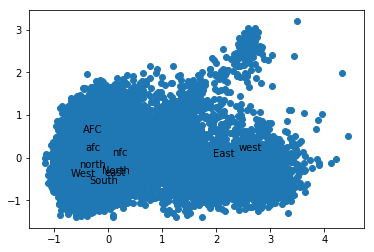

In [69]:
# Visualize the word vectors with a few labels WARNING: SOME INAPPROPRIATE WORDS MAY BE DISPLAYED
plt.scatter(pca_fit[:,0], pca_fit[:,1])
for i, word in enumerate(similar_words):
    plt.annotate(word, xy=(pca_fit[i, 0], pca_fit[i, 1]))
plt.show()